## ASSUMPTIONS OF MPT

- Investors are rational and avoid risks whenever possible

- Investors aim for the maximum returns for their investment

- All investors share the aim maximizing their expected returns

- Commissions and taxes on the market are left out of consideration

- All investors have access to the same sources and level of all necessary information about investment decisions

- Investors have unlimited access to borrow and lend money at the risk free rate

In [1]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

sns.set_style('darkgrid')
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline

## Read in Data from Quandl

In [2]:
with open('../quandl_key.txt', 'r') as f:
    quandl.ApiConfig.api_key = f.read()

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'F']
data = quandl.get_table('WIKI/PRICES', 
                        ticker=tickers,
                        qopts={'columns':['ticker', 'date', 'adj_close']},
                        date={'gte':'2014-1-1', 'lte':'2016-12-31'},
                        paginate=True
                       ).set_index('date')
data.head()

,ticker,adj_close
date,,
2016-12-30,MSFT,60.79
2016-12-29,MSFT,61.53
2016-12-28,MSFT,61.62
2016-12-27,MSFT,61.90
2016-12-23,MSFT,61.86


In [3]:
df = data.pivot(columns='ticker', values='adj_close')
df_ret = df.pct_change(1).dropna()
df_ret.head()

ticker,AAPL,AMZN,F,GOOG,MSFT
date,,,,,
2014-03-28,-0.00,-0.00,0.01,0.00,0.02
2014-03-31,-0.00,-0.01,0.01,-0.01,0.02
2014-04-01,0.01,0.02,0.05,0.02,0.01
2014-04-02,0.00,-0.00,0.01,-0.00,-0.00
2014-04-03,-0.01,-0.02,-0.00,0.00,-0.01


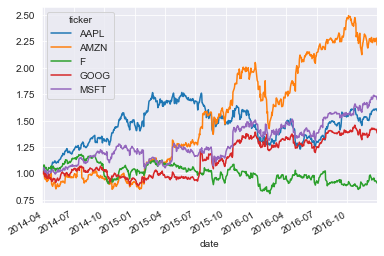

In [4]:
df_ret.add(1).cumprod().plot()

## Formulas

(1) $Annualized\ Return = (1 + cummulative\ return)^{(365\ /\ days\ held)} - 1$

(2) $Annualized\ Covariance = (Daily\ Covariance) * 252$

(3) $Variance = w^{T} \cdot (cov \cdot w)$

(4) $Correlation = \frac{cov}{std_{1} * std_{2}}$

In [5]:
df_ret.add(1).prod() ** (365 / df_ret.shape[0]) - 1

ticker
AAPL    0.28
AMZN    0.52
F      -0.05
GOOG    0.18
MSFT    0.32
dtype: float64

In [6]:
df_ret.cov() * 252

ticker,AAPL,AMZN,F,GOOG,MSFT
ticker,,,,,
AAPL,0.06,0.03,0.02,0.02,0.03
AMZN,0.03,0.10,0.02,0.04,0.03
F,0.02,0.02,0.05,0.02,0.02
GOOG,0.02,0.04,0.02,0.06,0.03
MSFT,0.03,0.03,0.02,0.03,0.06


### Simulate portfolio combinations

In [7]:
num_assets = len(tickers)
num_pfls = 50_000 # arbitrary

pfl_rets = []
pfl_vols = []
stk_weights = []

num_trade_days = 252
rets_annual = df_ret.add(1).prod() ** (num_trade_days / df_ret.shape[0]) - 1
cov_annual = df_ret.cov() * num_trade_days

for pfl in range(num_pfls):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    rets = np.dot(weights, rets_annual)
    vols = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    
    pfl_rets.append(rets)
    pfl_vols.append(vols)
    stk_weights.append(weights)
    
pfl_dic = {'Returns': pfl_rets,
           'Volatility':pfl_vols,
          }

for counter, symbol in enumerate(tickers):
    pfl_dic[symbol + '_weight'] = [weight[counter] for weight in stk_weights]
    
df = pd.DataFrame(pfl_dic)
df.head()

,Returns,Volatility,AAPL_weight,MSFT_weight,AMZN_weight,GOOG_weight,F_weight
0,0.19,0.20,0.32,0.27,0.08,0.30,0.03
1,0.14,0.19,0.15,0.21,0.32,0.16,0.16
2,0.14,0.19,0.06,0.25,0.29,0.29,0.12
3,0.16,0.20,0.02,0.27,0.26,0.24,0.21
4,0.24,0.21,0.24,0.39,0.02,0.10,0.25


In [8]:
df['Sharpe'] = df['Returns'] / df['Volatility']

sharpe_pfl = df[df['Sharpe'] == df['Sharpe'].max()]
min_vol_pfl = df[df['Volatility'] == df['Volatility'].min()]

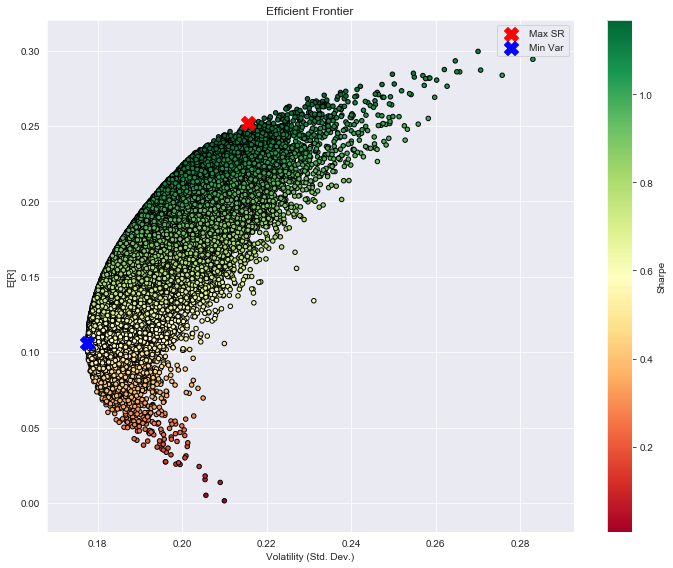

In [9]:
df.plot.scatter(x='Volatility', 
                y='Returns', 
                c='Sharpe',
                cmap='RdYlGn',
                edgecolors='black',
                figsize=(10,8),
                sharex=False, # must do to show x-ticks and label
                grid=True
               )

plt.scatter(x=sharpe_pfl['Volatility'], 
            y=sharpe_pfl['Returns'], 
            c='red',
            marker='X',
            s=200,
            label='Max SR'
           )
plt.scatter(x=min_vol_pfl['Volatility'], 
            y=min_vol_pfl['Returns'], 
            c='blue',
            marker='X',
            s=200,
            label='Min Var'
           )

plt.ylabel('E[R]')
plt.xlabel('Volatility (Std. Dev.)')
plt.title('Efficient Frontier')
plt.tight_layout()
plt.legend()

In [10]:
sharpe_pfl

,Returns,Volatility,AAPL_weight,MSFT_weight,AMZN_weight,GOOG_weight,F_weight,Sharpe
16189,0.25,0.22,0.29,0.43,0.01,0.02,0.26,1.17


In [12]:
min_vol_pfl

,Returns,Volatility,AAPL_weight,MSFT_weight,AMZN_weight,GOOG_weight,F_weight,Sharpe
48631,0.11,0.18,0.26,0.01,0.32,0.25,0.16,0.60


## Optimize function to find - (1) max SR & (2) min Vol - portfolios

In [13]:
from scipy.optimize import minimize

In [14]:
num_trade_days = 252
rets_annual = df_ret.add(1).prod() ** (num_trade_days / df_ret.shape[0]) - 1
rets_annual

ticker
AAPL    0.18
AMZN    0.33
F      -0.03
GOOG    0.12
MSFT    0.21
dtype: float64

### Optimized SR

In [15]:
def sharpe_ratio(weights):
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    ret = np.dot(rets_annual, weights)
    return -(ret / vol)

rets_annual = df_ret.add(1).prod() ** (num_trade_days / df_ret.shape[0]) - 1
cov_annual = df_ret.cov() * num_trade_days

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: x})
weights_0 = np.ones(len(tickers)) / len(tickers)
res = minimize(sharpe_ratio, x0=weights_0, constraints=constraints)

In [17]:
opt_weights = res.x

sharpe_pfl = {'Returns':np.dot(rets_annual, opt_weights),
              'Volatility':np.sqrt(np.dot(opt_weights.T, np.dot(cov_annual, opt_weights)))
             }
print(sharpe_pfl, sharpe_pfl['Returns'] / sharpe_pfl['Volatility'])
print({k:round(v, 2) for k,v in zip(tickers, opt_weights)})

{'Returns': 0.2586611302750126, 'Volatility': 0.21899543590782292} 1.1811256668558394
{'AAPL': 0.24, 'MSFT': 0.45, 'AMZN': -0.0, 'GOOG': 0.0, 'F': 0.31}


### Optimized Min Vol

In [20]:
def min_vol(weights):
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    return vol

rets_annual = df_ret.add(1).prod() ** (num_trade_days / df_ret.shape[0]) - 1
cov_annual = df_ret.cov() * num_trade_days

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: x})
weights_0 = np.ones(len(tickers)) / len(tickers)
res = minimize(min_vol, x0=weights_0, constraints=constraints)

In [21]:
opt_weights = res.x

min_vol_pfl = {'Returns':np.dot(rets_annual, opt_weights),
               'Volatility':np.sqrt(np.dot(opt_weights.T, np.dot(cov_annual, opt_weights)))
              }
print(min_vol_pfl, min_vol_pfl['Returns'] / min_vol_pfl['Volatility'])
print({k:round(v, 2) for k,v in zip(tickers, opt_weights)})

{'Returns': 0.10323390460930953, 'Volatility': 0.17757015251649952} 0.5813696904929854
{'AAPL': 0.26, 'MSFT': 0.01, 'AMZN': 0.33, 'GOOG': 0.23, 'F': 0.17}


Both similar to what was calculated using the simulation method above.

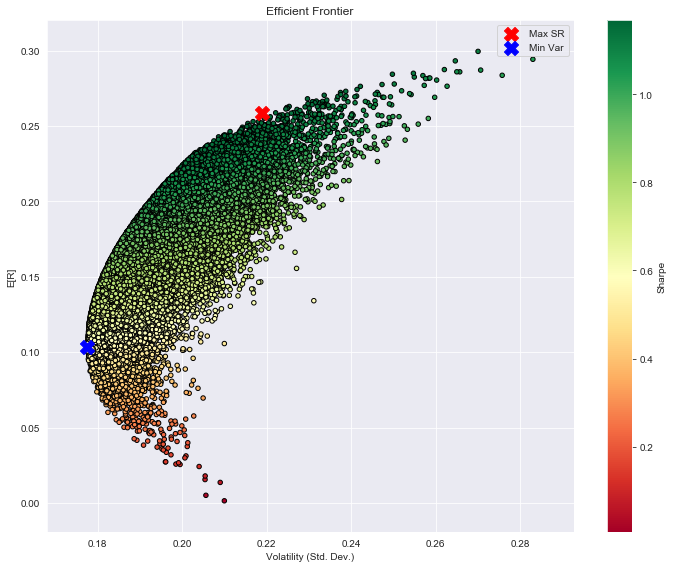

In [22]:
df.plot.scatter(x='Volatility', 
                y='Returns', 
                c='Sharpe',
                cmap='RdYlGn',
                edgecolors='black',
                figsize=(10,8),
                sharex=False, # must do to show x-ticks and label
                grid=True
               )

plt.scatter(x=sharpe_pfl['Volatility'], 
            y=sharpe_pfl['Returns'], 
            c='red',
            marker='X',
            s=200,
            label='Max SR'
           )
plt.scatter(x=min_vol_pfl['Volatility'], 
            y=min_vol_pfl['Returns'], 
            c='blue',
            marker='X',
            s=200,
            label='Min Var'
           )

plt.ylabel('E[R]')
plt.xlabel('Volatility (Std. Dev.)')
plt.title('Efficient Frontier')
plt.tight_layout()
plt.legend()

## Plot Efficient Frontier

In [23]:
ef_arr = []

for ret_const in np.arange(0, 0.31, 0.01):
    # add constraint for return equals given value
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: x},
                   {'type': 'eq', 'fun': lambda x: np.dot(rets_annual, x) - ret_const})

    res = minimize(min_vol, x0=weights_0, constraints=constraints)
    opt_weights = res.x
    
    ef_arr.append([np.sqrt(np.dot(opt_weights.T, np.dot(cov_annual, opt_weights))),
                   np.dot(rets_annual, opt_weights)]
                   )
    
ef_arr = np.array(ef_arr)

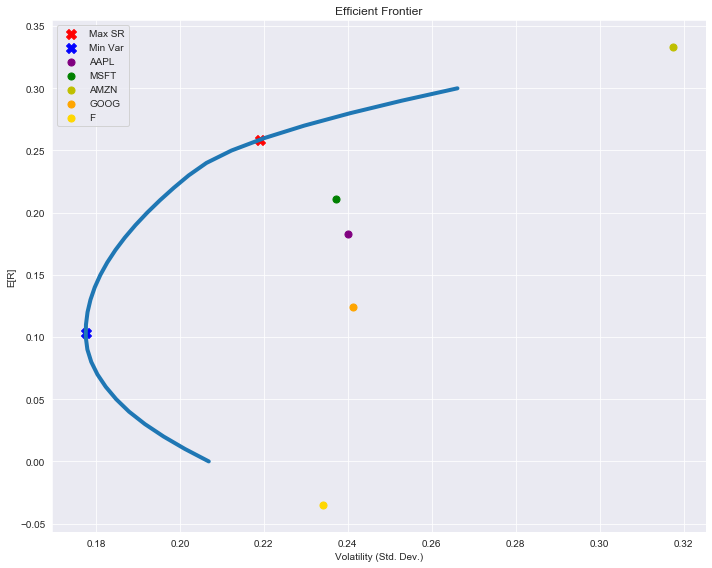

In [24]:
vol_annual = df_ret.std() * np.sqrt(252)

plt.figure(figsize=(10,8))

plt.plot(ef_arr[:, 0], 
         ef_arr[:, 1],
         linewidth=4.0
        )

plt.scatter(x=sharpe_pfl['Volatility'], 
            y=sharpe_pfl['Returns'], 
            c='red',
            marker='X',
            s=100,
            label='Max SR'
           )

plt.scatter(x=min_vol_pfl['Volatility'], 
            y=min_vol_pfl['Returns'], 
            c='blue',
            marker='X',
            s=100,
            label='Min Var'
           )

colors = ['purple', 'g', 'y', 'orange', 'gold']
for ticker, c in zip(tickers, colors[:len(tickers)]):
    plt.scatter(x=vol_annual[ticker], 
                y=rets_annual[ticker], 
                c=c,
                marker='o',
                s=50,
                label=ticker
                )

plt.ylabel('E[R]')
plt.xlabel('Volatility (Std. Dev.)')
plt.title('Efficient Frontier')
plt.tight_layout()
plt.legend()